In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../../../'))

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['HOME'] = '/data25/wuqin'

In [2]:
import torch
from src.arguments import ModelArguments, DataArguments
from src.model.model import MMEBModel
from src.model.processor import load_processor, QWEN2_VL, VLM_IMAGE_TOKENS, Qwen2_VL_process_fn
from src.utils import batch_to_device
from experiments.examples.qwen2vl.utils import show_tensor_image, split_to_grid, show_grid, tensor2pil
from experiments.examples.qwen2vl.vggt_utils import load_and_preprocess_images


# 初始化模型
model_args = ModelArguments(
    model_name='VLM2Vec/VLM2Vec-V2.0',
    pooling='last',
    normalize=True,
    model_backbone='qwen2_vl',
    lora=True
)
data_args = DataArguments()

processor = load_processor(model_args, data_args)
model = MMEBModel.load(model_args)
model = model.to('cuda', dtype=torch.bfloat16)
model = model.eval()

/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-07-31 08:55:59,660] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
[2025-07-31 08:55:59,668] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
[2025-07-31 08:56:00,251] DEBUG [matplotlib:342]

DropoutAddRMSNorm of flash_attn is not installed!!!


[2025-07-31 08:56:00,479] DEBUG [matplotlib:342] CACHEDIR=/data25/wuqin/.cache/matplotlib
[2025-07-31 08:56:00,482] DEBUG [matplotlib.font_manager:1635] Using fontManager instance from /data25/wuqin/.cache/matplotlib/fontlist-v390.json
[2025-07-31 08:56:00,651] INFO [src.utils:21] Loading processor from: VLM2Vec/VLM2Vec-V2.0
[2025-07-31 08:56:00,655] DEBUG [urllib3.connectionpool:1049] Starting new HTTPS connection (1): hf-mirror.com:443
[2025-07-31 08:56:01,810] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/preprocessor_config.json HTTP/1.1" 307 0
[2025-07-31 08:56:01,923] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /api/resolve-cache/models/VLM2Vec/VLM2Vec-V2.0/e39ff079b8275ef876d3656da8c0bddbff3c4dde/preprocessor_config.json HTTP/1.1" 200 0
[2025-07-31 08:56:02,238] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
[

In [1]:
from vggt_utils import load_and_preprocess_images
img = load_and_preprocess_images(["/data25/wuqin/projects/FlagEmbedding/research/visual_bge/vl_query_samples/imgs/test1.jpg"])
print(img.shape)

torch.Size([1, 3, 392, 518])


In [2]:
print(img.min(), img.max())

tensor(0.0078) tensor(1.)


[2025-07-31 08:56:19,189] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-07-31 08:56:19,193] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-07-31 08:56:19,197] DEBUG [matplotlib.font_manager:1471] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-07-31 08:56:19,198] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2025-07-31 08:56:19,198] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='nor

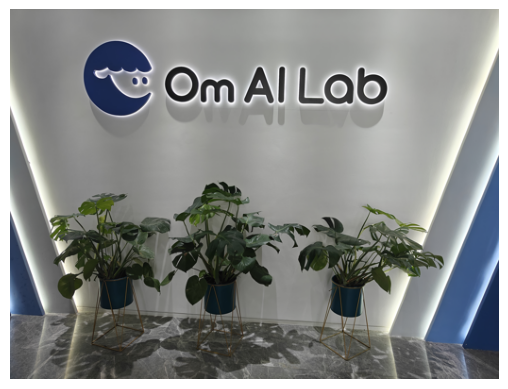

In [4]:
from utils import show_tensor_image
show_tensor_image(img)

## 多模态推理

输入图像文本对，将进入 LLM 之前的文本 embedding 的平均与图片 embedding 进行相似度计算

In [5]:
from utils import tensor2pil
prompt = "图中的植物部分"
inputs = processor(text=f'{VLM_IMAGE_TOKENS[QWEN2_VL]} {prompt}',
                images=tensor2pil(img[0]),
                return_tensors="pt")
inputs = {key: value.to('cuda') for key, value in inputs.items()}
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(0)
inputs['image_grid_thw'] = inputs['image_grid_thw'].unsqueeze(0)
with torch.no_grad():
    outputs = model.encoder(**inputs, return_dict=True, output_hidden_states=True, output_attentions=True)


In [6]:
print(outputs.keys())
print(len(outputs['attentions']), outputs['attentions'][-1].shape)

odict_keys(['logits', 'hidden_states', 'attentions', 'rope_deltas'])
28 torch.Size([1, 12, 256, 256])


In [7]:
# 分析注意力数据结构
print("=== 注意力数据结构分析 ===")
attention = outputs['attentions'][-1]  # 取最后一层的注意力
print(f"注意力张量形状: {attention.shape}")  # [batch_size, num_heads, seq_len, seq_len]

# 分析输入序列的组成
input_ids = inputs['input_ids']
print(f"输入序列长度: {input_ids.shape[1]}")
print(f"输入token IDs: {input_ids[0].tolist()}")

# 获取tokenizer来解析tokens
tokenizer = processor.tokenizer
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Token列表: {tokens}")

# 分析图像相关信息
print(f"图像网格信息 (thw): {inputs['image_grid_thw']}")
image_grid_thw = inputs['image_grid_thw'][0][0]  # [tiles, height, width]

=== 注意力数据结构分析 ===
注意力张量形状: torch.Size([1, 12, 256, 256])
输入序列长度: 256
输入token IDs: [151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 15165

In [8]:
# 识别图像和文本token的位置
def identify_token_positions(tokens, image_token_id=151655):  # Qwen2-VL的图像token ID
    """识别图像tokens和文本tokens的位置"""
    image_positions = []
    text_positions = []

    for i, token in enumerate(tokens):
        if token == '<|image_pad|>' or (hasattr(tokenizer, 'convert_tokens_to_ids') and
                                       tokenizer.convert_tokens_to_ids(token) == image_token_id):
            image_positions.append(i)
        elif token not in ['<|im_start|>', '<|im_end|>', '<|endoftext|>']:
            text_positions.append(i)

    return image_positions, text_positions

# 分析token位置
image_positions, text_positions = identify_token_positions(tokens)
print(f"图像token位置: {image_positions[:10]}...")  # 只显示前10个
print(f"文本token位置: {text_positions}")
print(f"图像token总数: {len(image_positions)}")
print(f"文本token总数: {len(text_positions)}")

图像token位置: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
文本token位置: [252, 253, 254, 255]
图像token总数: 252
文本token总数: 4


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import cv2

def extract_text_to_image_attention(attention, text_positions, image_positions, layer_idx=-1, head_idx=None):
    """
    提取文本tokens对图像patches的注意力权重

    Args:
        attention: 注意力张量 [batch, heads, seq_len, seq_len]
        text_positions: 文本token位置列表
        image_positions: 图像token位置列表
        layer_idx: 选择的层索引
        head_idx: 选择的头索引，None表示平均所有头

    Returns:
        text_to_image_attention: [num_text_tokens, num_image_tokens]
    """
    if layer_idx == -1:
        attention = outputs['attentions'][layer_idx]  # 最后一层
    else:
        attention = outputs['attentions'][layer_idx]

    # 选择batch的第一个样本
    attention = attention[0]  # [heads, seq_len, seq_len]

    # 处理多头注意力
    if head_idx is not None:
        attention = attention[head_idx]  # [seq_len, seq_len]
    else:
        attention = attention.mean(dim=0)  # 平均所有头 [seq_len, seq_len]

    # 提取文本对图像的注意力
    # attention[i, j] 表示位置i对位置j的注意力
    text_to_image_attn = attention[text_positions][:, image_positions]  # [num_text, num_image]

    return text_to_image_attn.cpu().float().numpy()

# 提取注意力权重
text_to_image_attn = extract_text_to_image_attention(
    attention, text_positions, image_positions
)
print(f"文本到图像注意力矩阵形状: {text_to_image_attn.shape}")
print(f"注意力值范围: [{text_to_image_attn.min():.4f}, {text_to_image_attn.max():.4f}]")

文本到图像注意力矩阵形状: (4, 252)
注意力值范围: [0.0000, 0.0388]


In [10]:
def reconstruct_image_attention(attention_weights, image_grid_thw, patch_size=14):
    """
    将1D的图像token注意力重构为2D空间注意力图

    Args:
        attention_weights: 对所有图像tokens的注意力权重 [num_image_tokens]
        image_grid_thw: 图像网格信息 [tiles, height, width]
        patch_size: patch的大小

    Returns:
        attention_map: 2D注意力图
    """
    tiles, height, width = image_grid_thw

    # 将1D注意力重构为网格形状
    # 注意：这里需要根据Qwen2-VL的具体实现来调整
    total_patches = height * width
    attention_2d = attention_weights[:total_patches].reshape(height, width)

    return attention_2d

def visualize_text_to_image_attention(original_image, text_tokens, text_to_image_attn,
                                    image_grid_thw, token_idx=0, save_path=None):
    """
    可视化特定文本token对图像的注意力分布

    Args:
        original_image: 原始图像张量
        text_tokens: 文本token列表
        text_to_image_attn: 文本到图像的注意力矩阵
        image_grid_thw: 图像网格信息
        token_idx: 要可视化的文本token索引
        save_path: 保存路径
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. 原始图像
    original_img_pil = tensor2pil(original_image)
    axes[0].imshow(original_img_pil)
    axes[0].set_title("原始图像")
    axes[0].axis('off')

    # 2. 注意力热力图
    attention_for_token = text_to_image_attn[token_idx]  # 选择特定文本token
    attention_2d = reconstruct_image_attention(attention_for_token, image_grid_thw)

    im1 = axes[1].imshow(attention_2d, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'文本token "{text_tokens[token_idx]}" 的注意力')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. 叠加可视化
    # 将注意力图缩放到原图尺寸
    original_img_np = np.array(original_img_pil)
    h, w = original_img_np.shape[:2]
    attention_resized = cv2.resize(attention_2d, (w, h))

    # 归一化注意力图
    attention_norm = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())

    # 创建热力图叠加
    heatmap = plt.cm.hot(attention_norm)[:, :, :3]  # 移除alpha通道
    overlay = 0.6 * original_img_np.astype(np.float32)/255.0 + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)

    axes[2].imshow(overlay)
    axes[2].set_title(f'注意力叠加图')
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# 准备可视化数据
text_tokens_clean = [tokens[i] for i in text_positions]
print(f"文本tokens: {text_tokens_clean}")

文本tokens: ['ĠåĽ¾', 'ä¸ŃçļĦ', 'æ¤įçī©', 'éĥ¨åĪĨ']


[2025-07-31 08:56:20,418] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492f7ffa990>
[2025-07-31 08:56:20,452] DEBUG [matplotlib.font_manager:1471] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[2025-07-31 08:56:20,453] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2025-07-31 08:56:20,454] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2025-07-31 08:56:20,455] DEBUG [matplotlib.font_manager


=== 可视化文本 token (索引: 0) ===


[2025-07-31 08:56:20,533] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-BlackItalic.ttf', name='Lato', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
[2025-07-31 08:56:20,533] DEBUG [matplotlib.font_manager:1515] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
/tmp/ipykernel_746386/854669079.py:70: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/854669079.py:70: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/854669079.py:70: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu S

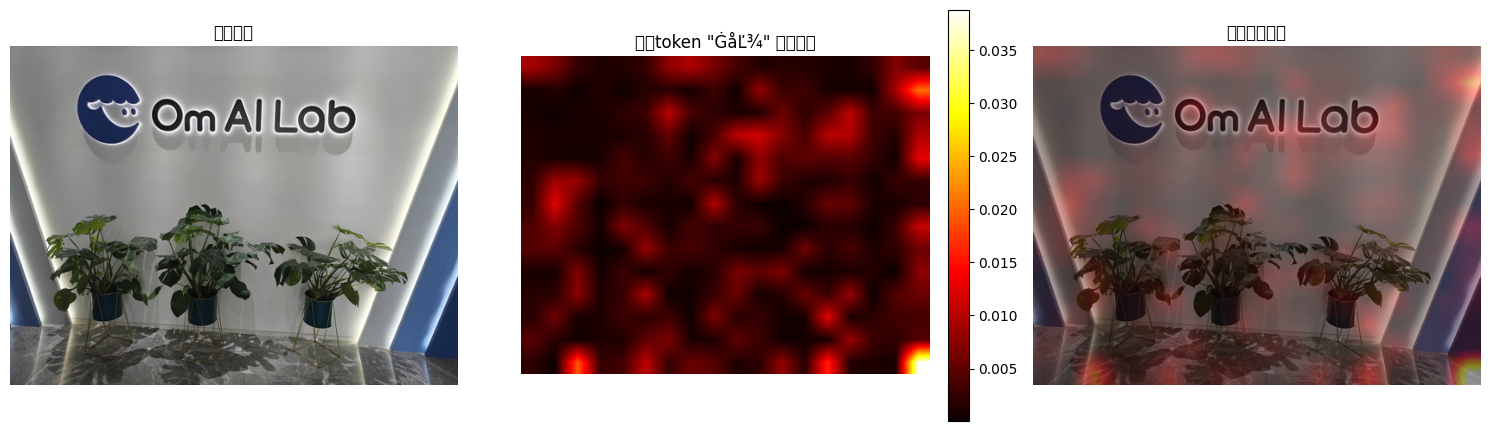

[2025-07-31 08:56:20,874] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492dc194810>



=== 可视化文本 token (索引: 1) ===


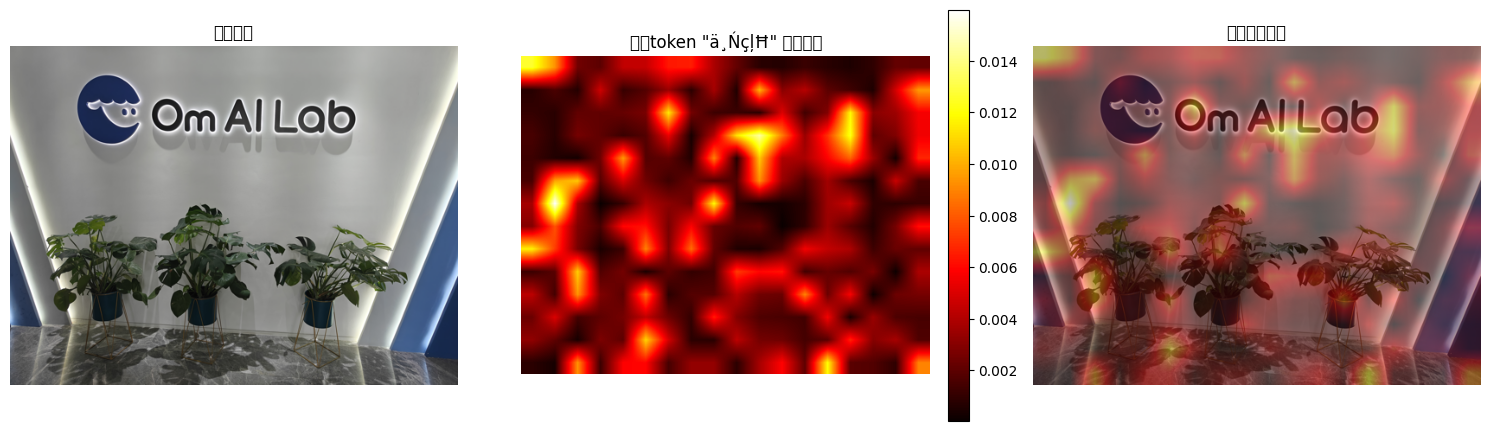

[2025-07-31 08:56:21,235] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492d4181010>



=== 可视化文本 token (索引: 2) ===


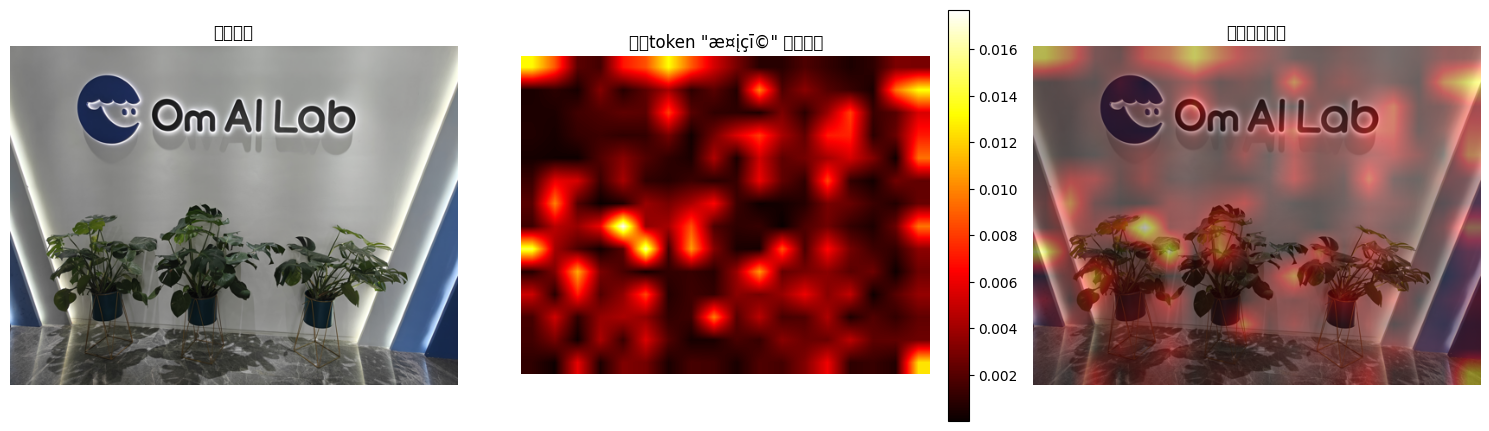

[2025-07-31 08:56:21,590] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492d418e610>



=== 可视化文本 token (索引: 3) ===


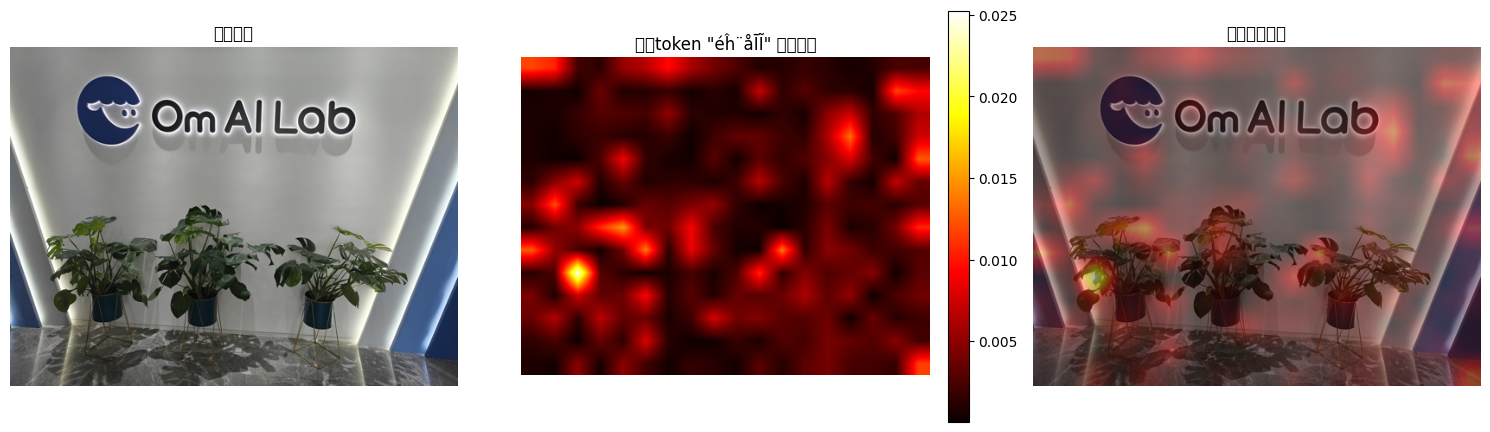

In [11]:
image_grid_thw = [1, 14, 18]
# 可视化每个文本token的注意力分布
for i, token in enumerate(text_tokens_clean):
    print(f"\n=== 可视化文本 token (索引: {i}) ===")
    visualize_text_to_image_attention(
        original_image=img[0],
        text_tokens=text_tokens_clean,
        text_to_image_attn=text_to_image_attn,
        image_grid_thw=image_grid_thw,
        token_idx=i
    )

[2025-07-31 08:56:22,225] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x14929d179110>
[2025-07-31 08:56:22,235] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492a41eec10>
[2025-07-31 08:56:22,245] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x14929d178350>
/tmp/ipykernel_746386/3536476142.py:36: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3536476142.py:36: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3536476142.py:36: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3536476142.py:36: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7

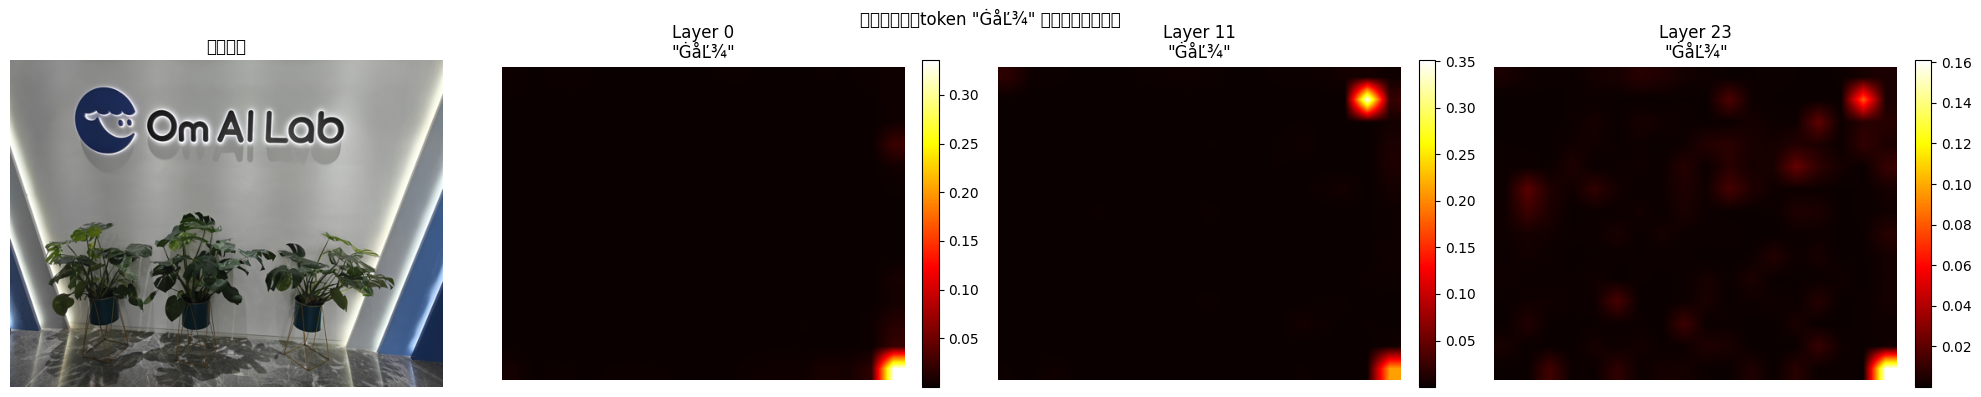

In [12]:
def compare_layers_attention(text_token_idx=0, layers_to_compare=[0, 11, 23]):
    """
    比较不同层的注意力模式

    Args:
        text_token_idx: 要分析的文本token索引
        layers_to_compare: 要比较的层索引列表
    """
    fig, axes = plt.subplots(1, len(layers_to_compare) + 1, figsize=(20, 4))

    # 显示原始图像
    original_img_pil = tensor2pil(img[0])
    axes[0].imshow(original_img_pil)
    axes[0].set_title("原始图像")
    axes[0].axis('off')

    token_name = text_tokens_clean[text_token_idx] if text_token_idx < len(text_tokens_clean) else "Unknown"

    for i, layer_idx in enumerate(layers_to_compare):
        # 提取该层的注意力
        layer_attention = extract_text_to_image_attention(
            None, text_positions, image_positions, layer_idx=layer_idx
        )

        # 重构注意力图
        attention_for_token = layer_attention[text_token_idx]
        attention_2d = reconstruct_image_attention(attention_for_token, image_grid_thw)

        # 可视化
        im = axes[i+1].imshow(attention_2d, cmap='hot', interpolation='bilinear')
        axes[i+1].set_title(f'Layer {layer_idx}\n"{token_name}"')
        axes[i+1].axis('off')
        plt.colorbar(im, ax=axes[i+1], fraction=0.046, pad=0.04)

    plt.suptitle(f'不同层中文本token "{token_name}" 的注意力模式对比')
    plt.tight_layout()
    plt.show()

# 执行多层对比可视化
if len(text_tokens_clean) > 0:
    compare_layers_attention(text_token_idx=0, layers_to_compare=[0, 11, 23])  # 浅层、中层、深层

[2025-07-31 08:56:22,660] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492ac1c2050>
[2025-07-31 08:56:22,670] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492dc1b4650>
[2025-07-31 08:56:22,679] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492dc143090>
[2025-07-31 08:56:22,690] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492d40fea50>
[2025-07-31 08:56:22,700] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492dc116750>
[2025-07-31 08:56:22,710] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492dc1eeed0>
[2025-07-31 08:56:22,722] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492e688a990>
[2025-07-31 08:56:22,733] DEBUG [matplotlib.colorbar:867] locator: <matplotlib.ticker.AutoLocator object at 0x1492e68e3250>
/tmp/ipy

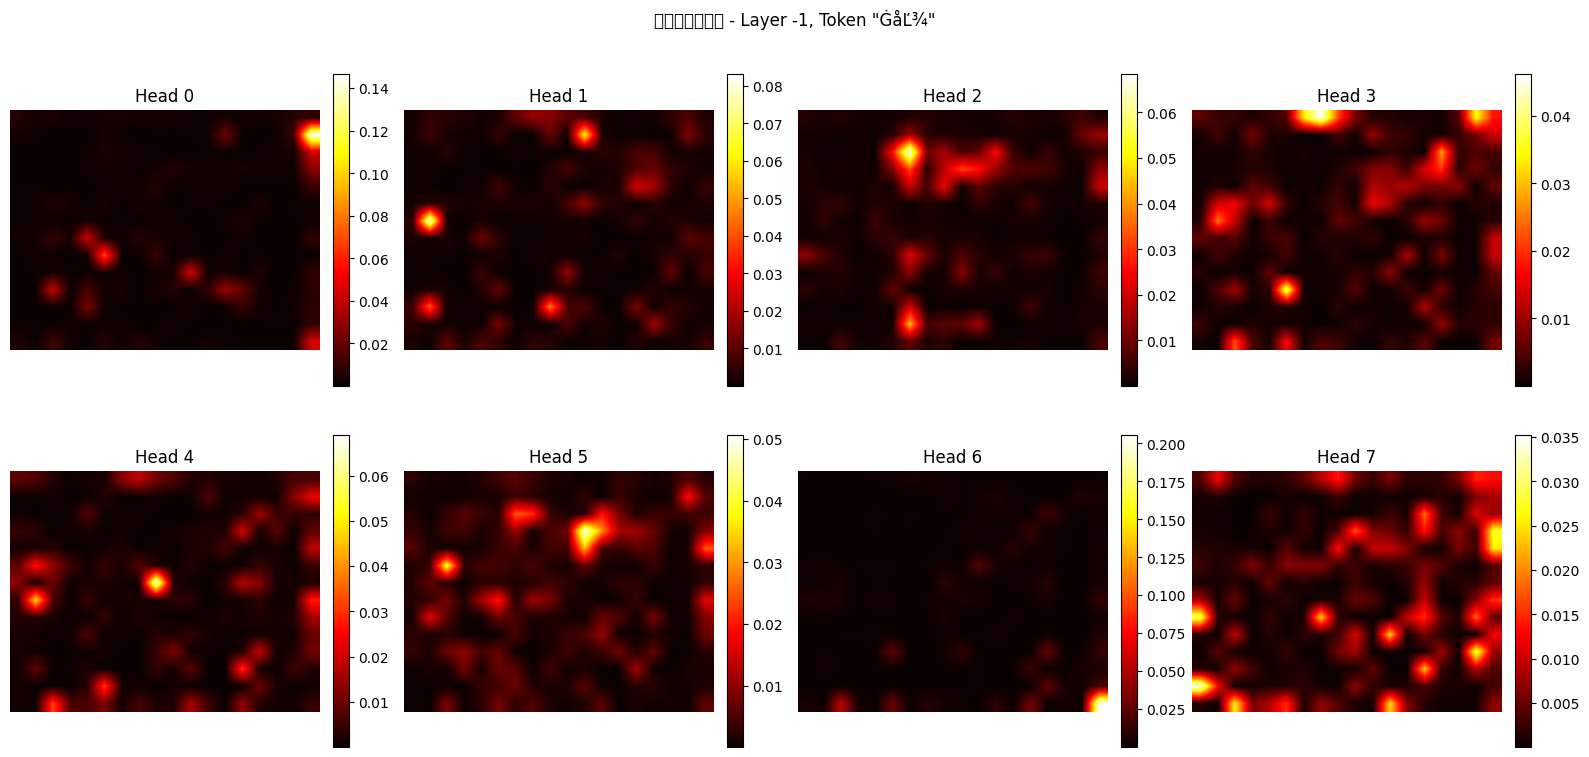

In [13]:
def analyze_multihead_attention(text_token_idx=0, layer_idx=-1, heads_to_show=8):
    """
    分析多头注意力的不同模式

    Args:
        text_token_idx: 文本token索引
        layer_idx: 层索引
        heads_to_show: 要显示的头数量
    """
    attention = outputs['attentions'][layer_idx][0]  # [heads, seq_len, seq_len]
    num_heads = attention.shape[0]
    heads_to_analyze = min(heads_to_show, num_heads)

    # 计算网格布局
    cols = 4
    rows = (heads_to_analyze + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    token_name = text_tokens_clean[text_token_idx] if text_token_idx < len(text_tokens_clean) else "Unknown"

    for head_idx in range(heads_to_analyze):
        row = head_idx // cols
        col = head_idx % cols

        # 提取该头的注意力
        head_attention = attention[head_idx]  # [seq_len, seq_len]
        text_to_image_attn_head = head_attention[text_positions][:, image_positions].cpu().float().numpy()

        # 重构注意力图
        attention_for_token = text_to_image_attn_head[text_token_idx]
        attention_2d = reconstruct_image_attention(attention_for_token, image_grid_thw)

        # 可视化
        im = axes[row, col].imshow(attention_2d, cmap='hot', interpolation='bilinear')
        axes[row, col].set_title(f'Head {head_idx}')
        axes[row, col].axis('off')

        # 添加colorbar
        plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

    # 隐藏多余的子图
    for head_idx in range(heads_to_analyze, rows * cols):
        row = head_idx // cols
        col = head_idx % cols
        axes[row, col].axis('off')

    plt.suptitle(f'多头注意力分析 - Layer {layer_idx}, Token "{token_name}"')
    plt.tight_layout()
    plt.show()

# 执行多头注意力分析
if len(text_tokens_clean) > 0:
    analyze_multihead_attention(text_token_idx=0, layer_idx=-1, heads_to_show=8)

=== 注意力统计分析 ===
注意力值统计:
  均值: 0.003355
  标准差: 0.003431
  最小值: 0.000015
  最大值: 0.038818

各文本token的注意力集中度:
  'ĠåĽ¾': 熵=5.0847, 最大注意力=0.0388
  'ä¸ŃçļĦ': 熵=5.1835, 最大注意力=0.0160
  'æ¤įçī©': 熵=5.1213, 最大注意力=0.0177
  'éĥ¨åĪĨ': 熵=5.1097, 最大注意力=0.0253


/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_746386/3743354575.py:55: UserWarning: Glyph 20998 (\N{CJK UNIFIED I

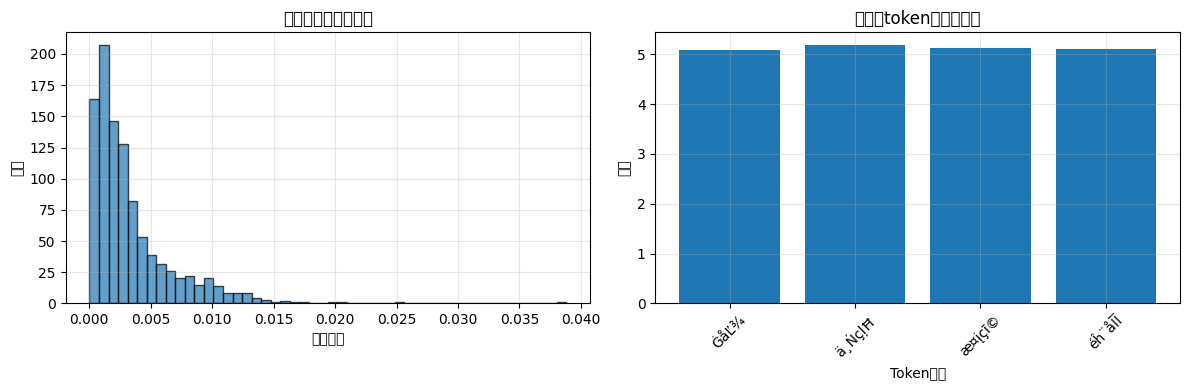

In [14]:
def attention_statistics_analysis():
    """
    对注意力模式进行统计分析
    """
    print("=== 注意力统计分析 ===")

    # 1. 整体注意力分布
    all_attention_values = text_to_image_attn.flatten()
    print(f"注意力值统计:")
    print(f"  均值: {np.mean(all_attention_values):.6f}")
    print(f"  标准差: {np.std(all_attention_values):.6f}")
    print(f"  最小值: {np.min(all_attention_values):.6f}")
    print(f"  最大值: {np.max(all_attention_values):.6f}")

    # 2. 每个文本token的注意力集中度
    print(f"\n各文本token的注意力集中度:")
    for i, token in enumerate(text_tokens_clean):
        token_attention = text_to_image_attn[i]
        # 计算熵来衡量注意力的集中程度
        # 熵越低，注意力越集中
        normalized_attention = token_attention / np.sum(token_attention)
        entropy = -np.sum(normalized_attention * np.log(normalized_attention + 1e-8))

        # 计算最大注意力位置
        max_attention_idx = np.argmax(token_attention)
        max_attention_value = token_attention[max_attention_idx]

        print(f"  '{token}': 熵={entropy:.4f}, 最大注意力={max_attention_value:.4f}")

    # 3. 可视化注意力分布直方图
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(all_attention_values, bins=50, alpha=0.7, edgecolor='black')
    plt.title('注意力值分布直方图')
    plt.xlabel('注意力值')
    plt.ylabel('频次')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    token_entropies = []
    for i in range(len(text_tokens_clean)):
        token_attention = text_to_image_attn[i]
        normalized_attention = token_attention / np.sum(token_attention)
        entropy = -np.sum(normalized_attention * np.log(normalized_attention + 1e-8))
        token_entropies.append(entropy)

    plt.bar(range(len(text_tokens_clean)), token_entropies)
    plt.title('各文本token的注意力熵')
    plt.xlabel('Token索引')
    plt.ylabel('熵值')
    plt.xticks(range(len(text_tokens_clean)), text_tokens_clean, rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 执行统计分析
attention_statistics_analysis()